In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from model_evaluate import evaluate_model
from tensorflow.keras.layers import Input 

In [13]:
# Step 1: Load Time-Series Data
train_data = pd.read_csv("train_timeseries.csv")
test_data = pd.read_csv("test_timeseries.csv")

feature_columns = [c for c in train_data.columns if c not in ['Time', 'PV_production', 'Wind_production']]
target_columns = ['PV_production', 'Wind_production']

print(f"Using {len(feature_columns)} features for training.")

X_train = train_data[feature_columns].values
y_train = train_data[target_columns].values
X_test = test_data[feature_columns].values
y_test = test_data[target_columns].values

Using 67 features for training.


In [14]:
# Step 2: Scale Data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [15]:
# Step 3: Sequence Creation
def make_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [16]:
# Step 4: Model Builder
def build_cnn_lstm(conv_act='relu', lstm_act='tanh', rec_act='sigmoid', dense_act='relu', input_shape=None):
    model = Sequential()
    # Use Input layer instead of passing input_shape to Conv1D
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation=conv_act, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64, activation=lstm_act, recurrent_activation=rec_act))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=dense_act))
    model.add(Dense(2, activation='linear'))  # outputs: PV & Wind
    model.compile(optimizer='adam', loss='mse')
    return model


In [17]:
# Step 5: Configurations
window_sizes = [12, 24, 48]
activation_combos = [
    ('relu', 'tanh', 'sigmoid', 'relu'),
    ('elu', 'tanh', 'sigmoid', 'relu'),
    ('selu', 'relu', 'hard_sigmoid', 'relu'),
    ('tanh', 'sigmoid', 'sigmoid', 'elu')
]

results_summary = []
tf.keras.utils.set_random_seed(42)

In [18]:
# Step 6: Train & Evaluate
for w in window_sizes:
    X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train_scaled, w)
    X_test_seq, y_test_seq = make_sequences(X_test_scaled, y_test_scaled, w)

    print(f"\n{'='*100}\nWindow size: {w}\n{'='*100}")
    for conv_act, lstm_act, rec_act, dense_act in activation_combos:
        print(f"→ Conv({conv_act}) + LSTM({lstm_act}/{rec_act}) + Dense({dense_act}) [window={w}]")

        model = build_cnn_lstm(conv_act, lstm_act, rec_act, dense_act,
                               input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
        early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)

        model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=64, validation_split=0.2,
                  callbacks=[early], verbose=0)

        y_pred_scaled = model.predict(X_test_seq, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test_seq)

        # --- compute metrics ---
        mae_pv = mean_absolute_error(y_true[:,0], y_pred[:,0])
        mae_wind = mean_absolute_error(y_true[:,1], y_pred[:,1])
        rmse_pv = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
        rmse_wind = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]))
        r2_pv = r2_score(y_true[:,0], y_pred[:,0])
        r2_wind = r2_score(y_true[:,1], y_pred[:,1])

        results_summary.append({
            'window': w,
            'conv': conv_act,
            'lstm': lstm_act,
            'rec': rec_act,
            'dense': dense_act,
            'r2_pv': r2_pv,
            'r2_wind': r2_wind,
            'r2_sum': r2_pv + r2_wind,
            'mae_pv': mae_pv,
            'mae_wind': mae_wind,
            'rmse_pv': rmse_pv,
            'rmse_wind': rmse_wind,
            'model': model,
            'y_true': y_true,
            'y_pred': y_pred
        })


Window size: 12
→ Conv(relu) + LSTM(tanh/sigmoid) + Dense(relu) [window=12]
→ Conv(elu) + LSTM(tanh/sigmoid) + Dense(relu) [window=12]
→ Conv(selu) + LSTM(relu/hard_sigmoid) + Dense(relu) [window=12]
→ Conv(tanh) + LSTM(sigmoid/sigmoid) + Dense(elu) [window=12]

Window size: 24
→ Conv(relu) + LSTM(tanh/sigmoid) + Dense(relu) [window=24]
→ Conv(elu) + LSTM(tanh/sigmoid) + Dense(relu) [window=24]
→ Conv(selu) + LSTM(relu/hard_sigmoid) + Dense(relu) [window=24]
→ Conv(tanh) + LSTM(sigmoid/sigmoid) + Dense(elu) [window=24]

Window size: 48
→ Conv(relu) + LSTM(tanh/sigmoid) + Dense(relu) [window=48]
→ Conv(elu) + LSTM(tanh/sigmoid) + Dense(relu) [window=48]
→ Conv(selu) + LSTM(relu/hard_sigmoid) + Dense(relu) [window=48]
→ Conv(tanh) + LSTM(sigmoid/sigmoid) + Dense(elu) [window=48]


In [19]:
# Step 7: Pick Best Model
best = max(results_summary, key=lambda r: r['r2_sum'])
best_model = best['model']
window_best = best['window']

print("\n" + "~"*90)
print("Best CNN+LSTM Configuration:")
print(f"Window Size: {window_best}")
print(f"Conv: {best['conv']} | LSTM: {best['lstm']}/{best['rec']} | Dense: {best['dense']}")
print(f"R² (PV): {best['r2_pv']:.3f}, R² (Wind): {best['r2_wind']:.3f}")
print("~"*90)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best CNN+LSTM Configuration:
Window Size: 48
Conv: tanh | LSTM: sigmoid/sigmoid | Dense: elu
R² (PV): 0.983, R² (Wind): 0.965
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


--- CNN+LSTM (window=48) - PV Production ---
MAE: 367.709
MSE: 299224.649
RMSE: 547.014
R²: 0.983
Adjusted R²: 0.983
Explained Variance: 0.987
Sample Size: 11616
Visualization Sample: 5,000 points


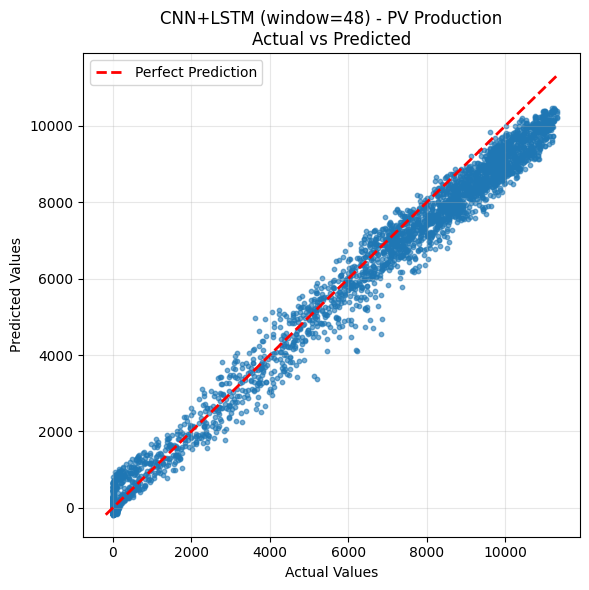

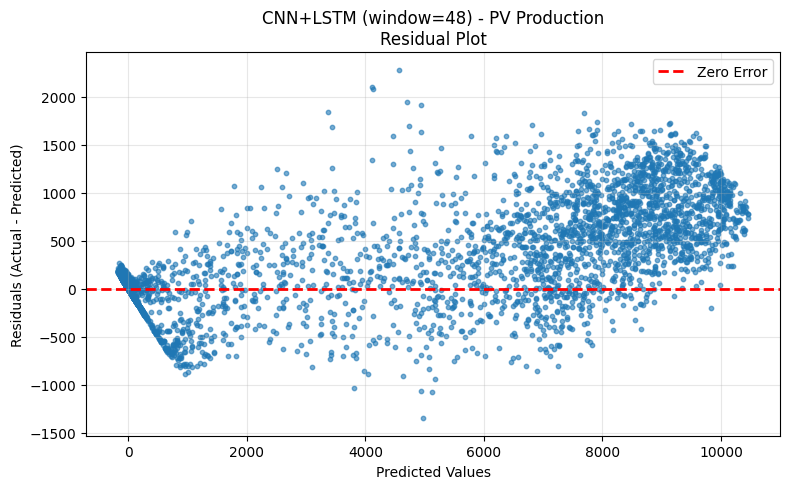

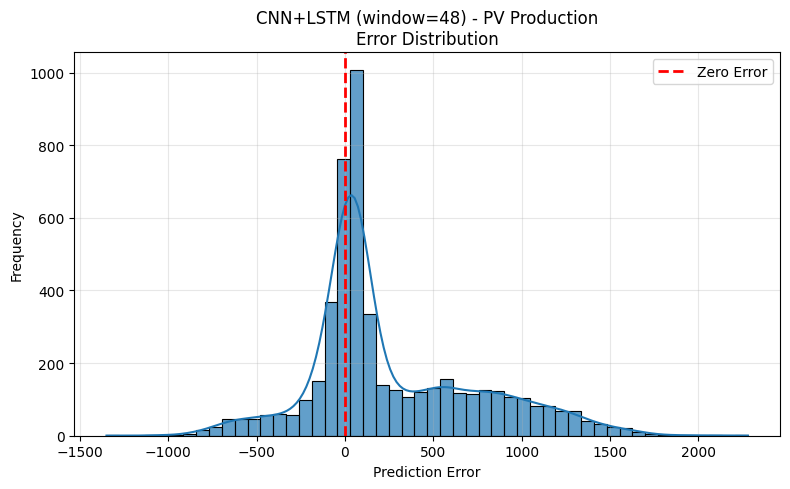

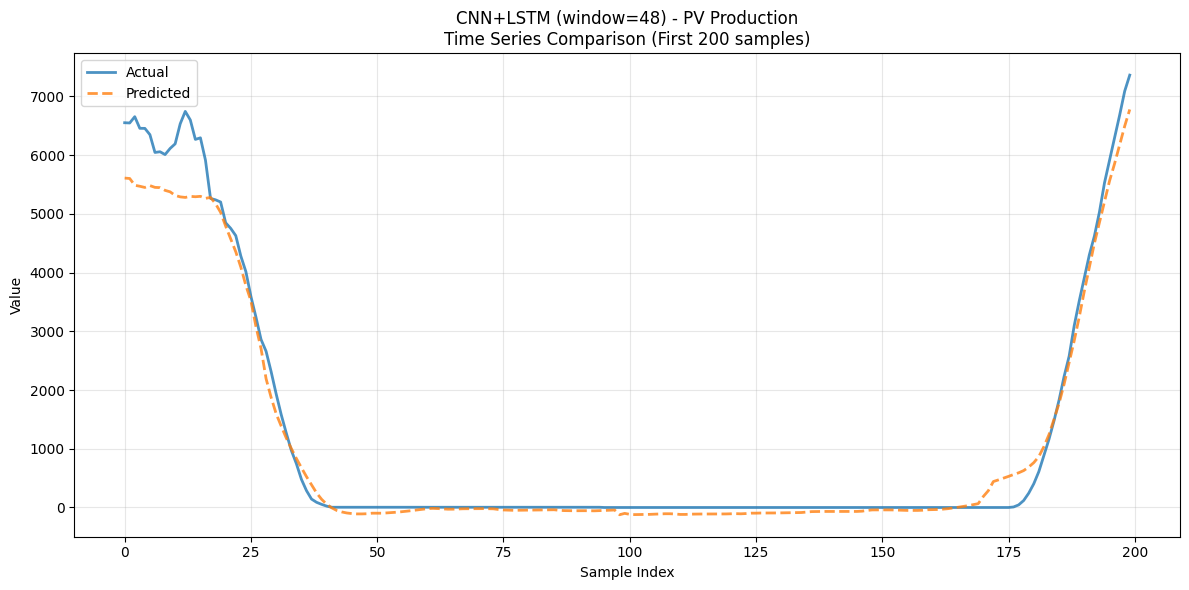

--- CNN+LSTM (window=48) - Wind Production ---
MAE: 178.476
MSE: 49222.711
RMSE: 221.862
R²: 0.965
Adjusted R²: 0.965
Explained Variance: 0.966
Sample Size: 11616
Visualization Sample: 5,000 points


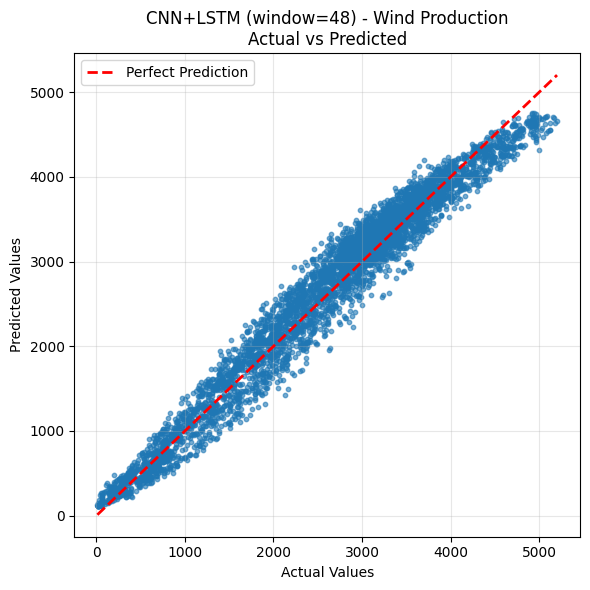

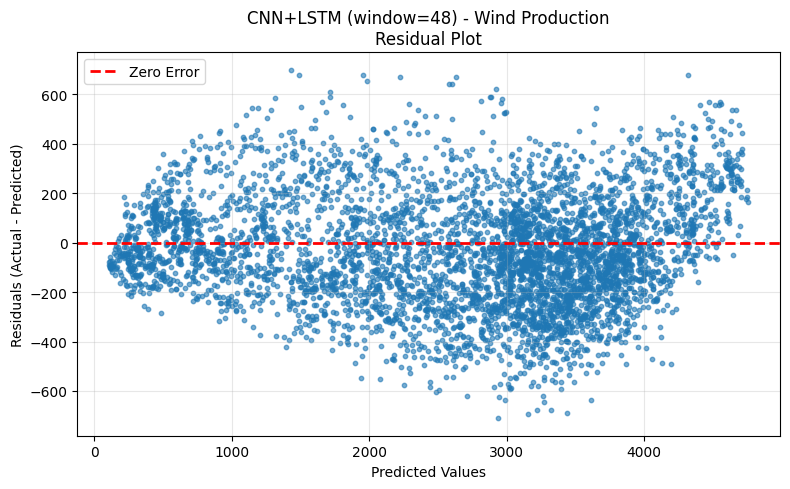

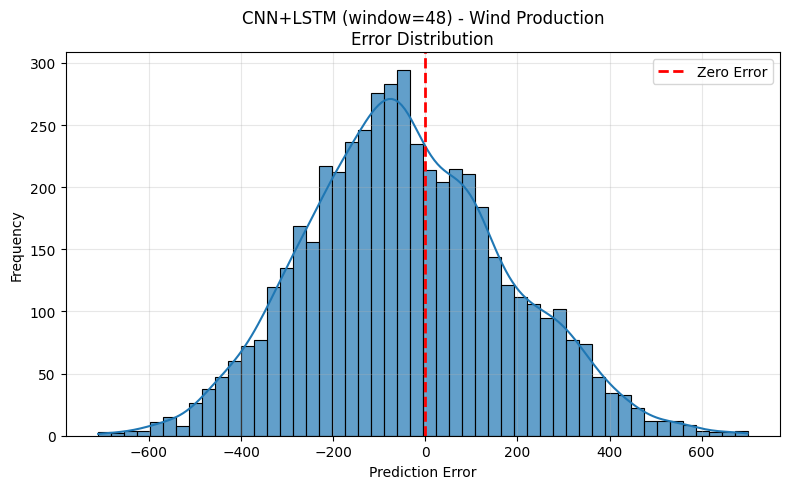

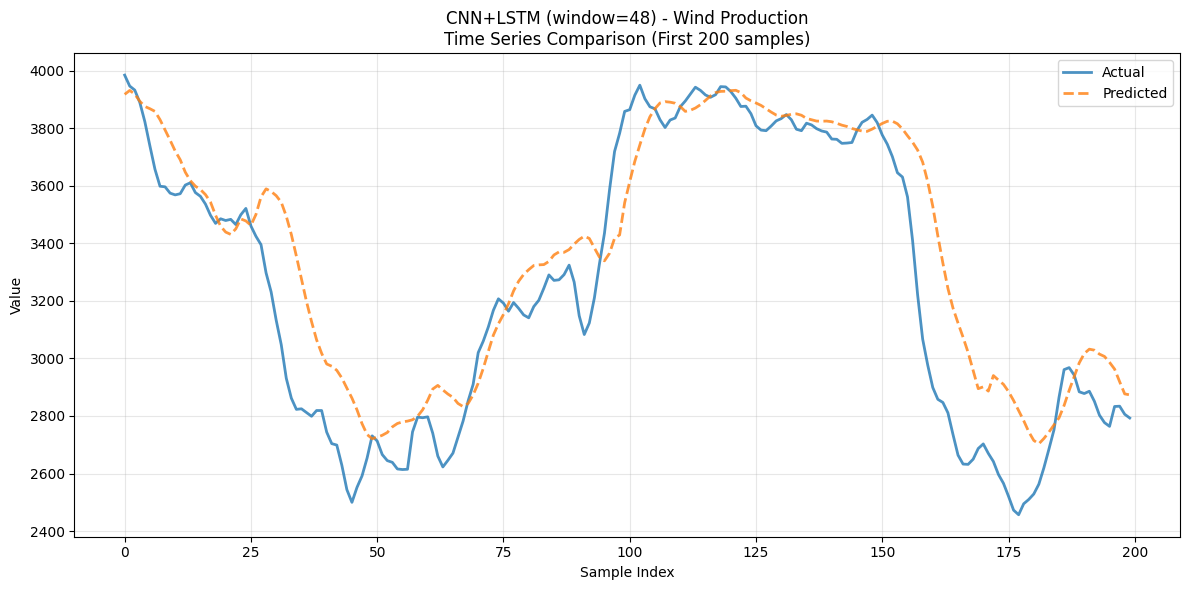

{'mae': np.float64(178.47605774619362),
 'mse': np.float64(49222.711075353785),
 'rmse': np.float64(221.86191893913156),
 'r2': 0.9650644959570817,
 'adj_r2': 0.9648618046883879,
 'explained_variance': 0.9662195400277992}

In [20]:
# Step 8: Evaluate Best Model
y_true = best['y_true']
y_pred = best['y_pred']

evaluate_model(
    y_true=y_true[:,0],
    y_pred=y_pred[:,0],
    model_name=f"CNN+LSTM (window={window_best})",
    target_name="PV Production",
    feature_names=feature_columns
)

evaluate_model(
    y_true=y_true[:,1],
    y_pred=y_pred[:,1],
    model_name=f"CNN+LSTM (window={window_best})",
    target_name="Wind Production",
    feature_names=feature_columns
)

In [21]:
# Step 9: Print Summary Table
print("\n~~~~~~~~ SUMMARY OF ALL CONFIGURATIONS ~~~~~~~~")
for r in results_summary:
    print(f"[w={r['window']:>2}] Conv({r['conv']}), LSTM({r['lstm']}/{r['rec']}), Dense({r['dense']}) → "
          f"R²_PV={r['r2_pv']:.3f}, R²_Wind={r['r2_wind']:.3f}, Sum={r['r2_sum']:.3f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


~~~~~~~~ SUMMARY OF ALL CONFIGURATIONS ~~~~~~~~
[w=12] Conv(relu), LSTM(tanh/sigmoid), Dense(relu) → R²_PV=0.969, R²_Wind=0.774, Sum=1.743
[w=12] Conv(elu), LSTM(tanh/sigmoid), Dense(relu) → R²_PV=0.962, R²_Wind=0.949, Sum=1.912
[w=12] Conv(selu), LSTM(relu/hard_sigmoid), Dense(relu) → R²_PV=0.986, R²_Wind=0.880, Sum=1.866
[w=12] Conv(tanh), LSTM(sigmoid/sigmoid), Dense(elu) → R²_PV=0.976, R²_Wind=0.921, Sum=1.897
[w=24] Conv(relu), LSTM(tanh/sigmoid), Dense(relu) → R²_PV=0.985, R²_Wind=0.739, Sum=1.724
[w=24] Conv(elu), LSTM(tanh/sigmoid), Dense(relu) → R²_PV=0.979, R²_Wind=0.836, Sum=1.815
[w=24] Conv(selu), LSTM(relu/hard_sigmoid), Dense(relu) → R²_PV=0.964, R²_Wind=0.938, Sum=1.902
[w=24] Conv(tanh), LSTM(sigmoid/sigmoid), Dense(elu) → R²_PV=0.986, R²_Wind=0.956, Sum=1.942
[w=48] Conv(relu), LSTM(tanh/sigmoid), Dense(relu) → R²_PV=0.994, R²_Wind=0.912, Sum=1.905
[w=48] Conv(elu), LSTM(tanh/sigmoid), Dense(relu) → R²_PV=0.960, R²_Wind=0.970, Sum=1.929
[w=48] Conv(selu), LSTM(relu/h

In [22]:
# Step 10: Print Final Best Metrics
mae_pv = best['mae_pv']
mae_wind = best['mae_wind']
rmse_pv = best['rmse_pv']
rmse_wind = best['rmse_wind']
mse_pv = rmse_pv ** 2
mse_wind = rmse_wind ** 2
n = len(y_true)
p = X_test.shape[1]

adj_r2_pv = 1 - (1 - best['r2_pv']) * (n - 1) / (n - p - 1)
adj_r2_wind = 1 - (1 - best['r2_wind']) * (n - 1) / (n - p - 1)

print("\n~~~~~ FINAL BEST MODEL METRICS ~~~~~")
print(f"Window Size: {window_best}")
print(f"CNN: {best['conv']} | LSTM: {best['lstm']}/{best['rec']} | Dense: {best['dense']}")
print(f"PV → MAE={mae_pv:.3f}, MSE={mse_pv:.3f}, RMSE={rmse_pv:.3f}, R²={best['r2_pv']:.3f}, Adj R²={adj_r2_pv:.3f}")
print(f"Wind → MAE={mae_wind:.3f}, MSE={mse_wind:.3f}, RMSE={rmse_wind:.3f}, R²={best['r2_wind']:.3f}, Adj R²={adj_r2_wind:.3f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



~~~~~ FINAL BEST MODEL METRICS ~~~~~
Window Size: 48
CNN: tanh | LSTM: sigmoid/sigmoid | Dense: elu
PV → MAE=367.709, MSE=299224.649, RMSE=547.014, R²=0.983, Adj R²=0.983
Wind → MAE=178.476, MSE=49222.711, RMSE=221.862, R²=0.965, Adj R²=0.965
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
